In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Get and Format the Data:

### Read Downloaded Kaggle Dataset:

In [2]:
fundamentals = pd.read_csv("./data/nyse/fundamentals.csv", parse_dates=['Period Ending'])
prices = pd.read_csv("./data/nyse/prices.csv", parse_dates=['date'])
prices_adj = pd.read_csv("./data/nyse/prices-split-adjusted.csv", parse_dates=['date'])
securities = pd.read_csv("./data/nyse/securities.csv", parse_dates=['Date first added'])

We are going to focus on the `prices_adj` dataset as our data and `securities` gives us our sector/subsector labels. `prices_adj` and `prices` are almost the same except that "prices_adj" has adjusted the dataset for stock splits (i.e. splitting single shares into several or vice versa, which changes the price accordingly since the company's value doesn't change. E.g. a 2-for-1 stock split means every share now becomes 2 shares, so there are twice as many shares but at half the price so that the total is the same. We don't want to incorporate these large price changes in our model so we only use `prices_adj`). The `fundamentals` dataset includes annual 10-k filings info, but this is not granular enough to be very useful for our models.

In [3]:
securities.rename(columns={'Ticker symbol':'symbol'},inplace=True)
securities.set_index(['symbol'], inplace=True, drop=True)
securities.sort_index(inplace=True)
securities.head()

,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
symbol,,,,,,,
A,Agilent Technologies Inc,reports,Health Care,Health Care Equipment,"Santa Clara, California",NaT,1090872
AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201
AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
AAPL,Apple Inc.,reports,Information Technology,Computer Hardware,"Cupertino, California",1982-11-30,320193
ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152


In [4]:
securities.loc['AMZN']

Security                                       Amazon.com Inc
SEC filings                                           reports
GICS Sector                            Consumer Discretionary
GICS Sub Industry          Internet & Direct Marketing Retail
Address of Headquarters                   Seattle, Washington
Date first added                          2005-11-18 00:00:00
CIK                                                   1018724
Name: AMZN, dtype: object

### First let's see what we're working with:

In [5]:
prices_adj.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [6]:
prices_adj.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


We have the opening, closing, highest and lowest prices for each security in each day, as well as the volume traded in number of shares. We would like this to be a bit more standardized across observations. In particular, the absolute price level of each security varies widely and is not particularly important to us (although this is debatable as some research indicates that very high or very low stock prices can influence investor behavior and market dynamics/structure, we will not explore this here). 

Instead, we want to focus on price changes from day to day, which is generally what investors are interested in: will a stock go up or down and by what percentage? So we calculate price changes from the previous closing price (a somewhat arbitrary, but industry standard choice of benchmark) and we can do this for each of the open, close, high, and low prices of the day, as follows:

### Get Percent Changes:

In [7]:
# First, index dataframe by symbol and date:
symbols = sorted(prices_adj['symbol'].unique())
prices_adj.set_index(['symbol', 'date'], inplace=True, drop=True)
prices_adj.sort_index(inplace=True)

In [8]:
# Then calculate the percent move from the previous close for each daily price field:
prices_adj["percent_change_close-close"]=(prices_adj['close'].shift(1)-prices_adj['close'])/prices_adj['close']
prices_adj["percent_change_close-open"]=(prices_adj['open'].shift(1)-prices_adj['close'])/prices_adj['close']
prices_adj["percent_change_close-low"]=(prices_adj['low'].shift(1)-prices_adj['close'])/prices_adj['close']
prices_adj["percent_change_close-high"]=(prices_adj['high'].shift(1)-prices_adj['close'])/prices_adj['close']

print(prices_adj.head())

                        open      close        low       high     volume  \
symbol date                                                                
A      2010-01-04  22.453504  22.389128  22.267525  22.625180  3815500.0   
       2010-01-05  22.324749  22.145923  22.002861  22.331903  4186000.0   
       2010-01-06  22.067240  22.067240  22.002861  22.174536  3243700.0   
       2010-01-07  22.017168  22.038626  21.816881  22.045780  3095100.0   
       2010-01-08  21.917024  22.031474  21.745350  22.067240  3733900.0   

                   percent_change_close-close  percent_change_close-open  \
symbol date                                                                
A      2010-01-04                         NaN                        NaN   
       2010-01-05                    0.010982                   0.013889   
       2010-01-06                    0.003566                   0.011669   
       2010-01-07                    0.001298                   0.001298   
       2010

------
# Choosing Modeling Problems and Corresponding Data Formats
Now we have a nice dataset here with the percent moves from the previous close to the open, close, high and low prices of each day, as well as the old raw values of those prices and the volume traded if we still want it, for each trading day from the start of 2010 through the end 2016, for each ticker in the S&P 500 over that span. Now, we want to think about what sort of questions we want to ask of the data.

The most obvious question we might ask is, given price moves of the previous n trading days in a particular ticker or of the broader market, can we reliably predict where the price will go in the next trading session or over the next k days, both as a binary up or down indicator and as an actual predicted price using regression. We can do this by using a sliding window to take samples of days for our features, leaving the price of the next day or the price some number of days in the future as the label or predicted variable. However, it is not clear that many standard machine learning techniques should be very successful at determining time-series trends, thus we also consider doing some Feature Engineering, to summarize some of the important time-series information in the windows as features to aid in classification/regression. We will explore this later on.

First, we look at an arguably simpler, or at least more straight-forward, machine learning application of classifying companies by their corresponding sector labels using the price changes as the data. We will explore classification using supervised learning via Nearest Neighbors, Naive Bayes', and Random Forest, dimensionality reduction using Principal Component Analysis, as well as experimenting with hierarchical clustering to see if we can identify sub-industry splits as well as groupings of similar sectors.

----
## 1) Sector Analysis, Classification & Clustering

We want observations to correspond to single companies, incorporating all of their price moves as features. Our hypothesis is that companies in similar industries will move together more often than not. Thus our initial thought is that Nearest-Neighbor and clustering techniques should be very successful, but we test other methods and compare results with commentary. Ultimately, Naive-Bayes has been the most successful, followed by Random Forest, which may be partially due to the reasonability of the assumption that features for different days are independent (although this is obviously not true for high, low, open and close features of a single day) but also the high-dimensionality of the data and potential influence of outlying days. We test several implementations of Nearest Neighbors classification to mitigate these issues with some success.

The first day has no previous close to calculate from so let's `NaN` that out:

In [9]:
daily_prices_by_symbol = prices_adj.unstack('date')
daily_prices_by_symbol['percent_change_close-close',pd.Timestamp('2010-01-04')]=np.NaN
daily_prices_by_symbol['percent_change_close-open',pd.Timestamp('2010-01-04')]=np.NaN
daily_prices_by_symbol['percent_change_close-high',pd.Timestamp('2010-01-04')]=np.NaN
daily_prices_by_symbol['percent_change_close-low',pd.Timestamp('2010-01-04')]=np.NaN
daily_price_changes_by_symbol=daily_prices_by_symbol[['percent_change_close-close','percent_change_close-open','percent_change_close-high','percent_change_close-low']]
daily_price_changes_by_symbol

percent_change_close-close                                              \
date                   2010-01-04 2010-01-05 2010-01-06 2010-01-07 2010-01-08   
symbol                                                                          
A                             NaN   0.010982   0.003566   0.001298   0.000325   
AAL                           NaN  -0.101695   0.043222  -0.028626   0.019455   
AAP                           NaN   0.005979  -0.008644   0.000247  -0.003937   
AAPL                          NaN  -0.001726   0.016163   0.001852  -0.006604   
ABBV                          NaN        NaN        NaN        NaN        NaN   
ABC                           NaN   0.007186   0.009546   0.016298  -0.010749   
ABT                           NaN   0.008145  -0.005523  -0.008216  -0.005086   
ACN                           NaN  -0.006142  -0.010519   0.000936   0.003993   
ADBE                          NaN  -0.016180   0.002127   0.019789   0.005451   
ADI                           NaN   0.001581   0.001901   0.007985  -0.005716   
ADM                           NaN  -0.005373   0.002535   0.010567   0.012646   
ADP                           NaN   0.005399   0.002353   0.000471   0.001414   
ADS                           NaN  -0.001969  -0.004974  -0.009110  -0.010638   
ADSK                          NaN   0.015427  -0.002368  -0.005495  -0.029703   
AEE                           NaN   0.003978   0.006919   0.009559   0.007034   
AEP                           NaN   0.011581  -0.010031  -0.008525  -0.011794   
AES                           NaN   0.010347   0.010456  -0.000746  -0.027576   
AET                           NaN   0.014448   0.004012  -0.030811   0.022324   
AFL                           NaN  -0.028192  -0.008708  -0.010619   0.010119   
AGN                           NaN   0.010028  -0.003248   0.008060   0.007359   
AIG                           NaN   0.019093   0.006520   0.019594  -0.025903   
AIV                           NaN  -0.024450  -0.017417  -0.035342   0.023725   
AIZ                           NaN  -0.028976   0.002906  -0.012121  -0.000638   
AJG                           NaN   0.005403  -0.000450   0.006341  -0.002710   
AKAM                          NaN  -0.028850   0.008311  -0.000378   0.000000   
ALB                           NaN   0.001841  -0.001838   0.007139  -0.014848   
ALK                           NaN  -0.051930   0.009053   0.005240   0.020259   
ALL                           NaN  -0.016176  -0.000323  -0.005148  -0.004165   
ALLE                          NaN        NaN        NaN        NaN        NaN   
ALXN                          NaN   0.014508  -0.002517  -0.003761  -0.001877   
...                           ...        ...        ...        ...        ...   
VZ                            NaN  -0.001800   0.044486   0.005988  -0.000630   
WAT                           NaN   0.013818  -0.001806  -0.004251  -0.000817   
WBA                           NaN   0.008108   0.007625  -0.005956  -0.001352   
WDC                           NaN  -0.025829  -0.000860   0.019961  -0.005020   
WEC                           NaN   0.013244  -0.010085   0.002021  -0.005827   
WFC                           NaN  -0.026719  -0.001423  -0.035015   0.009355   
WFM                           NaN   0.008327  -0.011453   0.004313  -0.005007   
WHR                           NaN   0.002079   0.008882  -0.021015  -0.020814   
WLTW                          NaN        NaN        NaN        NaN        NaN   
WM                            NaN   0.004411   0.000294  -0.002347  -0.004673   
WMB                           NaN  -0.012340  -0.031430   0.007133  -0.007961   
WMT                           NaN   0.010058   0.002240  -0.000560   0.005063   
WRK                           NaN        NaN        NaN        NaN        NaN   
WU                            NaN   0.004208   0.000526  -0.031107  -0.009596   
WY                            NaN  -0.020787   0.011181   0.004492   0.009295   
WYN                           NaN  -0.

We note that some tickers have several days missing. We have three options:

1) Ignore tickers with missing days

2) Ignore days with missing tickers

3) Replace missing values (e.g. with averages or zeros)

First we want to check how many symbols have missing data, and how many days are missing for each. We find that many days are missing for not too many tickers, so we focus on option 1) and then explore option 2). We were wary of option 3) given that we want to emphasize clustering and we suspect this would cause points with many filled values to cluster together and also we already have a fairly high-dim feature space (so can afford to lose some data).

In [10]:
print(daily_price_changes_by_symbol.shape)
num_days_missing=daily_price_changes_by_symbol['percent_change_close-close'].isnull().sum(1)
print(sum(num_days_missing>1))
print(num_days_missing[num_days_missing>1])
daily_price_changes_by_symbol=daily_price_changes_by_symbol.dropna(1,'all')
print(daily_price_changes_by_symbol)
daily_price_changes_by_symbol=daily_price_changes_by_symbol.dropna()
print(daily_price_changes_by_symbol)
print(daily_price_changes_by_symbol.shape)

(501, 7048)
33
symbol
ABBV     754
ALLE     976
CFG     1258
COTY     866
CSRA    1478
DLPH     754
EVHC     909
FB       754
FBHS     754
FTV     1636
GM       222
HCA      754
HPE     1458
KHC     1384
KMI      754
KORS     754
LYB       79
MNK      868
MPC      754
NAVI    1258
NLSN     754
NWS      870
NWSA     870
PSX      754
PYPL    1384
QRVO    1258
SYF     1258
TDG      754
TRIP     754
WLTW    1511
WRK     1377
XYL      754
ZTS      775
dtype: int64
       percent_change_close-close                                              \
date                   2010-01-05 2010-01-06 2010-01-07 2010-01-08 2010-01-11   
symbol                                                                          
A                        0.010982   0.003566   0.001298   0.000325  -0.000649   
AAL                     -0.101695   0.043222  -0.028626   0.019455   0.019841   
AAP                      0.005979  -0.008644   0.000247  -0.003937   0.009940   
AAPL                    -0.001726   0.016163   0.0

We remove those 33 securities with missing days from the dataset and the sector labels. We also note that a lot of securities have 754 days missing (presumably a large rebalance day for the S&P) so we later experiment with keeping those securities and only the days for which we have their data, and finally we also include all of the securities (except for FTV which only has ~100 trading days).

In [11]:
filtered_securities=securities[list(map(lambda x: x in daily_price_changes_by_symbol.index.values,securities.index.values))]
print(filtered_securities['GICS Sector'])
sector_labels=np.array(filtered_securities['GICS Sector'])
sub_sector_labels=np.array(filtered_securities['GICS Sub Industry'])
print(np.shape(sector_labels))
print(np.shape(sub_sector_labels))

symbol
A                       Health Care
AAL                     Industrials
AAP          Consumer Discretionary
AAPL         Information Technology
ABC                     Health Care
ABT                     Health Care
ACN          Information Technology
ADBE         Information Technology
ADI          Information Technology
ADM                Consumer Staples
ADP          Information Technology
ADS          Information Technology
ADSK         Information Technology
AEE                       Utilities
AEP                       Utilities
AES                       Utilities
AET                     Health Care
AFL                      Financials
AGN                     Health Care
AIG                      Financials
AIV                     Real Estate
AIZ                      Financials
AJG                      Financials
AKAM         Information Technology
ALB                       Materials
ALK                     Industrials
ALL                      Financials
ALXN                 

## Okay, Let's Actually Do Some Machine Learning!

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

We take random permutations of the data for training and evaluation:

In [13]:
daily_close=np.array(daily_price_changes_by_symbol['percent_change_close-close'])
daily_all=np.array(daily_price_changes_by_symbol)

shuffle = np.random.permutation(np.arange(sector_labels.shape[0]))
daily_close, daily_all, sector_labels, sub_sector_labels = daily_close[shuffle], daily_all[shuffle], sector_labels[shuffle], sub_sector_labels[shuffle]

train_indices=list(range(374))
dev_indices=list(range(374,421))
test_indices=list(range(421,468))

###### Now let's start simply by taking a look at the data by using PCA to project down to 2-d:

Percentage of variance explained by each of the first 50 principal components individually:
PC #1 Percent varaince explained = 9.38%, Total Percent varaince explained = 9.38%
PC #2 Percent varaince explained = 4.80%, Total Percent varaince explained = 14.18%
PC #3 Percent varaince explained = 2.72%, Total Percent varaince explained = 16.90%
PC #4 Percent varaince explained = 2.10%, Total Percent varaince explained = 19.00%
PC #5 Percent varaince explained = 1.91%, Total Percent varaince explained = 20.91%
PC #6 Percent varaince explained = 1.77%, Total Percent varaince explained = 22.68%
PC #7 Percent varaince explained = 1.58%, Total Percent varaince explained = 24.25%
PC #8 Percent varaince explained = 1.52%, Total Percent varaince explained = 25.77%
PC #9 Percent varaince explained = 1.45%, Total Percent varaince explained = 27.22%
PC #10 Percent varaince explained = 1.29%, Total Percent varaince explained = 28.51%
PC #11 Percent varaince explained = 1.23%, Total Percent varaince ex

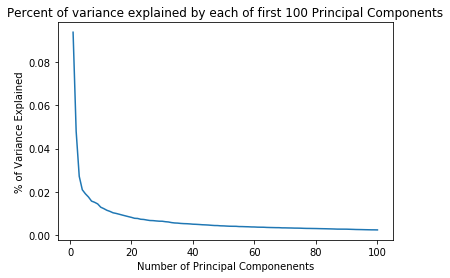

In [14]:
pca=PCA(n_components=100)
pca.fit(daily_all[train_indices])
print("Percentage of variance explained by each of the first 50 principal components individually:")
list(map(lambda x: print('PC #%d Percent varaince explained = %.2f%%, Total Percent varaince explained = %.2f%%' %(x+1,round(pca.explained_variance_ratio_[x],4)*100,round(sum(pca.explained_variance_ratio_[:x+1]),4)*100)),range(100)))
plt.plot(list(range(1,101)),pca.explained_variance_ratio_)
plt.title('Percent of variance explained by each of first 100 Principal Components')
plt.xlabel('Number of Principal Componenents')
plt.ylabel('% of Variance Explained')
plt.show()

In [15]:
pca=PCA(n_components=100)
pca.fit(daily_all[train_indices])
list(map(lambda x: print('First %d Prin Comp Total Percent varaince explained = %.2f%%' %(x+1,round(sum(pca.explained_variance_ratio_[:x+1]),4)*100)),range(100)))

First 1 Prin Comp Total Percent varaince explained = 9.38%
First 2 Prin Comp Total Percent varaince explained = 14.18%
First 3 Prin Comp Total Percent varaince explained = 16.90%
First 4 Prin Comp Total Percent varaince explained = 19.00%
First 5 Prin Comp Total Percent varaince explained = 20.91%
First 6 Prin Comp Total Percent varaince explained = 22.68%
First 7 Prin Comp Total Percent varaince explained = 24.25%
First 8 Prin Comp Total Percent varaince explained = 25.77%
First 9 Prin Comp Total Percent varaince explained = 27.22%
First 10 Prin Comp Total Percent varaince explained = 28.51%
First 11 Prin Comp Total Percent varaince explained = 29.74%
First 12 Prin Comp Total Percent varaince explained = 30.89%
First 13 Prin Comp Total Percent varaince explained = 31.99%
First 14 Prin Comp Total Percent varaince explained = 33.02%
First 15 Prin Comp Total Percent varaince explained = 34.03%
First 16 Prin Comp Total Percent varaince explained = 34.99%
First 17 Prin Comp Total Percent v

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

['Consumer Discretionary' 'Consumer Staples' 'Energy' 'Financials'
 'Health Care' 'Industrials' 'Information Technology' 'Materials'
 'Real Estate' 'Telecommunications Services' 'Utilities']


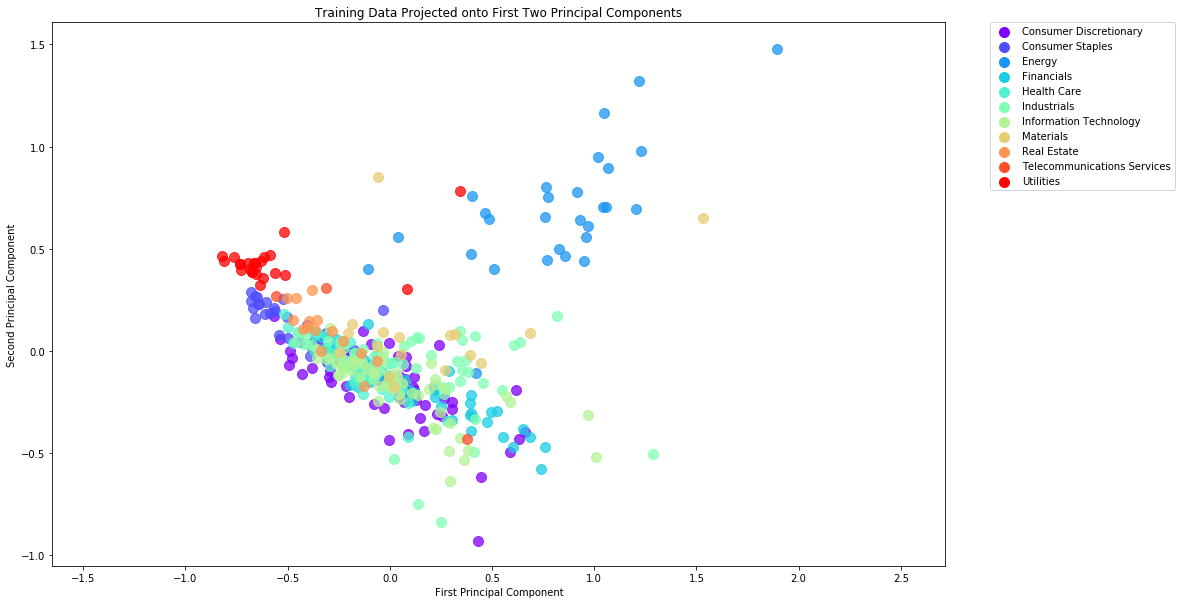

In [16]:
import matplotlib.cm as cm

pca=PCA(n_components=2)
train_data=np.array(pca.fit_transform(daily_all[train_indices]))
train_labels=sector_labels[train_indices]
labels=np.unique(sector_labels)
print(labels)
colors = cm.rainbow(np.linspace(0, 1, len(labels)))
plt.figure(figsize=(16,10))
ax=plt.gca()
ax.axis('equal')
for label,color in zip(labels,colors):
    ax.scatter([], [], s=100, c=color,alpha=1,label=label)
    ax.scatter(train_data[train_labels==label, 0], train_data[train_labels==label, 1], s=100, c=color,alpha=.75)
plt.title('Training Data Projected onto First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')    
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

###### PCA Notes:

From a clustering perspective this doesn't look terrible, but not extremely promising. We can see `Energy` and `Utilities` form fairly distinct clusters and there is some separation of the other groups, but there is more overlap. However it is important to note that the feature space is of very high-dimensionality and that the first two principal components account for only ~22.5% of the variance in the dataset, so the one big cluster may separate more nicely than it appears in a higher-dim space. 
___

# On to the Supervised Learning:

## Nearest Neighbors
Let's start with k-NN. There aren't very many labels per class so we're probably going to need to keep k fairly low or test other distance based voting schemes. Alternatively we can play around with excluding sectors with poor support and evenly distributing data across other sectors, but we already don't have a lot of data so we might be wary of this. We also may be worried about the high-dimensionality of the data for using k-NN, so we may want to consider dimensionality reduction techniques or tree-based processing using ball-trees or other data structures.

In [17]:
for k in map(lambda x: 2*x+1,range(5)):
    print('Results using all daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      0.60      0.55         5
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.78      0.88         9
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.50      1.00      0.67         2
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.84      0.77      0.77        47

Classification Accuracy: 0.7659574468085106
Results usin

We obtain a high of just over 87% accuracy (**note: these results may change slightly when rerun given random permutation of data*) with `k=1`, which is not terrible but not great for what should be the simpler problem. We were using the percent changes from the previous close to the high, low, open and close here. Let's try just close to close changes to cut down dimensionality:

In [18]:
for k in map(lambda x: 2*x+1,range(5)):
    print('Results using only daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using only daily close features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.67      0.57      0.62         7
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       0.67      0.50      0.57         4
     Information Technology       0.60      0.50      0.55         6
                  Materials       0.50      1.00      0.67         2
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.80      0.79      0.78        47

Classification Accuracy: 0.7872340425531915
Resul

No dice. Results are slightly worse here, with the best being 81% accuracy (**note: these results may change slightly when rerun given random permutation of data*) with `k=1`, so about the same. Another thing to note is that moves on different days are not weighted equally. Even though all of the numbers are percent moves, some days are going to have much wilder moves across different sectors than others. Perhaps we wanted to overemphasize these days in our decision making, but let's see what happens when we instead normalize all features to have mean 0 and standard deviation 1.

In [19]:
normalized_daily_close=(daily_close-daily_close.mean(0))/daily_close.std(0)
print(normalized_daily_close.shape)
normalized_daily_all=(daily_all-daily_all.mean(0))/daily_all.std(0)
print(normalized_daily_all.shape)

(468, 1761)
(468, 7044)


In [20]:
for k in map(lambda x: 2*x+1,range(5)):
    print('Results using all normalized daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    print('Results using only normalized daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all normalized daily features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      0.50      0.50         6
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.40      0.50      0.44         4
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.82      0.74      0.75        47

Classification Accuracy: 0.7446808510638298
R

                             precision    recall  f1-score   support

     Consumer Discretionary       0.33      1.00      0.50         2
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.35      0.52        20
                Health Care       0.50      1.00      0.67         2
                Industrials       0.00      0.00      0.00         3
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.80      0.62      0.62        47

Classification Accuracy: 0.6170212765957447


Again not really any better, although for there is a slight improvement when using only the normalized close-to-close feature per day, yielding 85% Accuracy (**note: these results may change slightly when rerun given random permutation of data*) for `k=1`.

### Nearest Neighbors with PCA
Let's try using PCA for dimensionality reduction by projecting onto the first 100 principal componenets:

In [21]:
pca=PCA(n_components=100)
pca.fit(daily_all[train_indices])
daily_all_pca=pca.transform(daily_all)
print(daily_all_pca.shape)
train_data,dev_data,test_data=daily_all_pca[train_indices],daily_all_pca[dev_indices],daily_all_pca[test_indices]
for k in map(lambda x: 2*x+1,range(5)):
    print('Results using all daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data,sector_labels[train_indices])
    result=classification_report(model.predict(dev_data),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(dev_data)==sector_labels[dev_indices])/len(dev_indices))

(468, 100)
Results using all daily features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.62      0.71         8
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       0.67      0.67      0.67         3
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.75      1.00      0.86         3
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.89      0.87      0.87        47

Classification Accuracy: 0.8723404255319149
R

Comparable but slightly worse results of 85% accuracy (**note: these results may change slightly when rerun given random permutation of data*) with `k=1`. It is worth noting that PCA might not be the most valid dimensionality reduction technique here, compared to say Compressed Sensing, which provides a dimensionality reduction which better preserves pairwise-distances between points and thus may be more applicable as preprocessing for Nearest Neighbor classification. We do not explore this here.

### Nearest Neighbors with Distance-based Vote
One way of getting around the poor distribution of labels, or at least just another way of running the Nearest Neighbors Classifier, is rather than having an equal weighted vote of nearest neighbors, we weight votes by the inverse of the distance to those neighbors, increasing the impact of closer points. Let's try it here:

In [22]:
for k in range(1,26):
    print('Results using all daily features with k = %d weighted inversely to their distance'%k)
    model = KNeighborsClassifier(n_neighbors=k,weights='distance')
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with k = 1 weighted inversely to their distance
                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      0.60      0.55         5
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.78      0.88         9
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.50      1.00      0.67         2
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.84      0.77      0.77        47

Classification Accu

                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      1.00      0.67         3
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.70      0.82        10
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.33      0.50         9
     Information Technology       0.80      0.80      0.80         5
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.89      0.77      0.77        47

Classification Accuracy: 0.7659574468085106
Results using all daily features with k = 10 weighted in

                             precision    recall  f1-score   support

     Consumer Discretionary       0.33      1.00      0.50         2
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.50      0.67        14
                Health Care       0.50      1.00      0.67         2
                Industrials       1.00      0.30      0.46        10
     Information Technology       0.60      1.00      0.75         3
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.62      1.00      0.77         5
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      0.75      0.86         4

                avg / total       0.86      0.66      0.67        47

Classification Accuracy: 0.6595744680851063
Results using all daily features with k = 18 weighted in

                             precision    recall  f1-score   support

     Consumer Discretionary       0.33      1.00      0.50         2
           Consumer Staples       0.75      0.75      0.75         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.47      0.64        15
                Health Care       0.50      1.00      0.67         2
                Industrials       1.00      0.30      0.46        10
     Information Technology       0.60      1.00      0.75         3
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.50      1.00      0.67         4
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      0.50      0.67         6

                avg / total       0.85      0.60      0.62        47

Classification Accuracy: 0.5957446808510638


Of course with `k=1` this is identical to the equal weighted case, thus we obtain equivalent results here and no improvement for larger values of k. We included even k values since ties are now decided by the distance to the point in question.

### Nearest Neighbors Using Manhattan Distance
To decrease the influence of outliers we can also try switching to the `Manhattan` distance instead of the default `Euclidean` distance:

In [23]:
for k in map(lambda x: 2*x+1,range(5)):
    print('Results using all daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k,p=1)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    print('Results using only daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k,p=1)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
    print('Results using all normalized daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k,p=1)
    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    print('Results using only normalized daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k,p=1)
    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.33      0.67      0.44         3
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.27      0.43        11
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.50      1.00      0.67         2
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.85      0.74      0.73        47

Classification Accuracy: 0.7446808510638298
Results usin

                             precision    recall  f1-score   support

     Consumer Discretionary       0.67      1.00      0.80         4
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.58      0.74        12
                Health Care       0.75      1.00      0.86         3
                Industrials       0.67      0.29      0.40         7
     Information Technology       0.60      1.00      0.75         3
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.84      0.77      0.76        47

Classification Accuracy: 0.7659574468085106
Results using all normalized daily features with k = 5
 

                             precision    recall  f1-score   support

     Consumer Discretionary       0.33      1.00      0.50         2
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.78      0.88         9
                Health Care       0.50      1.00      0.67         2
                Industrials       1.00      0.27      0.43        11
     Information Technology       0.80      0.67      0.73         6
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.88      0.72      0.73        47

Classification Accuracy: 0.723404255319149
Results using only normalized daily close features with k

There isn't any improvement here, but it is interesting that changing the distance metric seemed to improve results for higher values of k, and for results using only close-to-close or using normalized features.

### Nearest Neighbors Using Trees
As a final test, to help overcome the dimensionality issues, we will incorporate the ball-tree and kd-tree data structures into our Nearest Neighbor algorithm. From my understanding, this is a speedup that can not provide improvement of results, but it seemed worth trying anyway:

In [24]:
for k in map(lambda x: 2*x+1,range(5)):
    for algorithm in ['ball_tree','kd_tree','brute']:
        print('Results using the algorithm %s and all daily features with k = %d:'%(algorithm,k))
        model = KNeighborsClassifier(n_neighbors=k,algorithm=algorithm)
        model.fit(daily_all[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using the algorithm ball_tree and all daily features with k = 1:
                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      0.60      0.55         5
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.78      0.88         9
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.50      1.00      0.67         2
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.84      0.77      0.77        47

Classification Accuracy: 0.

                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      0.60      0.55         5
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.54      0.70        13
                Health Care       0.75      1.00      0.86         3
                Industrials       0.67      0.29      0.40         7
     Information Technology       0.40      0.67      0.50         3
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.78      0.68      0.69        47

Classification Accuracy: 0.6808510638297872
Results using the algorithm kd_tree and all daily featur

All data-structures produced the same results, somewhat as expected.

-----

## Naive-Bayes
Another algorithm we'd like to try is Naive Bayes'. In particular, we hypothesize it may be particularly amenable to the current task given both the high-dimensionality of the data and the applicability of the mutual independence assumtion of features given that each day's moves should be largely independent. This is not entirely valid of course, in that we also expect there to be trends that extend over periods of time and then subside, and furthermore we expect that different features from the same days should be related, so it is possible that using only close-to-close features will fare better in this setting.

In [25]:
best=0
for alpha in map(lambda x: 10**(x-5),range(10)):
    model=BernoulliNB(alpha=alpha)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all normalized daily features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
    model=BernoulliNB(alpha=alpha)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only daily close features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
print("Highest accuracy over all tests =",best)

Results using all daily features with alpha = 1e-05
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.56      0.67         9
           Consumer Staples       0.75      1.00      0.86         3
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.38      0.55         8
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.89      0.81      0.81        47

Classification Accuracy: 0.8085106382978723
Resu

Results using all normalized daily features with alpha = 0.001
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.71      0.77         7
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      0.83      0.91         6
                  Materials       0.75      1.00      0.86         3
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.90      0.85      0.86        47

Classification Accuracy: 0.8510638297

Results using all normalized daily features with alpha = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.71      0.77         7
           Consumer Staples       1.00      0.80      0.89         5
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.75      1.00      0.86         3
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.90      0.87      0.87        47

Classification Accuracy: 0.87234042553191

Results using all normalized daily features with alpha = 1000
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      1.00      0.91         5
           Consumer Staples       1.00      0.67      0.80         6
                     Energy       1.00      0.67      0.80         3
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      0.60      0.75         5

                avg / total       0.93      0.81      0.84        47

Classification Accuracy: 0.80851063829

Naive-Bayes' Classifier provides a slight improvement over the Nearest Neighbors Classifier, with best classification results coming from using all daily features (unnormalized) and an alpha value of 10 producing an accuracy of over 89%. This is only a marginal improvement over the Nearest Neighbors algorithm results above, but over several trials, Nearest Neighbor results tended to be lower than the above and Naive-Bayes the same or better than here, and always producing cases that beat the Nearest Neighbors approach, suggesting that it is the more applicable classifier here.

-----
## Random Forest
We decided to also try the Random Forest Classifier for different numbers of trees:

In [26]:
best=0
for n_estimators in range(40,61):
    model=RandomForestClassifier(n_estimators=n_estimators)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)

    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all normalized daily features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
    model=RandomForestClassifier(n_estimators=n_estimators)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only daily close features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
    
    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only normalized daily close features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    if np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
        best=np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
        
print("Highest accuracy over all tests =",best)

Results using all daily features with n_estimators = 40
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.55      0.71        11
           Consumer Staples       0.75      1.00      0.86         3
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.43      0.60         7
     Information Technology       0.80      1.00      0.89         4
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.94      0.81      0.83        47

Classification Accuracy: 0.8085106382978723


Results using all normalized daily features with n_estimators = 42
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.50      0.67        12
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      0.50      0.50         2
                 Financials       1.00      0.88      0.93         8
                Health Care       1.00      1.00      1.00         4
                Industrials       0.67      0.67      0.67         3
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.93      0.81      0.84        47

Classification Accuracy: 0.808510

Results using only daily close features with n_estimators = 44
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.60      0.75        10
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      0.80      0.89         5
                Industrials       1.00      0.60      0.75         5
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.94      0.85      0.87        47

Classification Accuracy: 0.8510638297

Results using only normalized daily close features with n_estimators = 46
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.46      0.63        13
           Consumer Staples       0.75      1.00      0.86         3
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      0.88      0.93         8
                Health Care       0.75      1.00      0.86         3
                Industrials       1.00      0.60      0.75         5
     Information Technology       0.80      0.80      0.80         5
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.90      0.77      0.80        47

Classification Accuracy: 0

Results using all daily features with n_estimators = 49
                             precision    recall  f1-score   support

     Consumer Discretionary       0.67      0.50      0.57         8
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.80      0.80      0.80         5
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.86      0.79      0.79        47

Classification Accuracy: 0.7872340425531915


Results using all normalized daily features with n_estimators = 51
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.83      0.83         6
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.43      0.60         7
     Information Technology       1.00      0.71      0.83         7
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.95      0.83      0.86        47

Classification Accuracy: 0.829787

Results using only daily close features with n_estimators = 53
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      1.00      1.00         6
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      0.71      0.83         7
                  Materials       0.25      1.00      0.40         1
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      0.75      0.86         4

                avg / total       0.95      0.87      0.89        47

Classification Accuracy: 0.8723404255

Results using only normalized daily close features with n_estimators = 55
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.56      0.67         9
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      0.71      0.83         7
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.93      0.81      0.84        47

Classification Accuracy: 0

Results using all daily features with n_estimators = 58
                             precision    recall  f1-score   support

     Consumer Discretionary       0.83      0.56      0.67         9
           Consumer Staples       0.75      1.00      0.86         3
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.38      0.55         8
     Information Technology       0.80      0.80      0.80         5
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.90      0.79      0.81        47

Classification Accuracy: 0.7872340425531915


Results using all normalized daily features with n_estimators = 60
                             precision    recall  f1-score   support

     Consumer Discretionary       0.67      0.50      0.57         8
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       0.50      1.00      0.67         1
                 Financials       1.00      1.00      1.00         7
                Health Care       1.00      0.80      0.89         5
                Industrials       1.00      0.50      0.67         6
     Information Technology       1.00      0.71      0.83         7
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.90      0.79      0.82        47

Classification Accuracy: 0.787234

Random Forest matched the Naive Bayes' high of 89% classification on this permutation, and for some datasets and number of trees was able to consitently provide results in the low to mid 80%'s, however other permutations still showed better accuracy of Naive Bayes' than Random Forests. Interestingly, Random Forest generally performed best on the daily close features (unnormalized) dataset.

----
## Support Vector Machines
Finally, we though it was worth implementing classification via Support Vector Machines. Given the high-dimensionality of the data and potential non-linearity of trends, SVM may be able to fare better than other classifiers.

In [27]:
best=0
for C in map(lambda x: 10**(x-2),range(5)):
    for kernel in ['linear','rbf','sigmoid']:
        model=SVC(C=C,kernel=kernel)
        model.fit(daily_all[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
        print("Results using all daily features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
        if np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
            best=np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
        
        model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
        print("Results using all normalized daily features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
        if np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
            best=np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
        
        model=SVC(C=C,kernel=kernel)
        model.fit(daily_close[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
        print("Results using only daily close features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
        if np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
            best=np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
        
        model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
        print("Results using only normalized daily close features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
        if np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)>best:
            best=np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices)
        
print("Highest accuracy over all tests =",best)

Results using all daily features with linear kernel and C = 0.010000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.13      0.23        47
           Consumer Staples       0.00      0.00      0.00         0
                     Energy       0.00      0.00      0.00         0
                 Financials       0.00      0.00      0.00         0
                Health Care       0.00      0.00      0.00         0
                Industrials       0.00      0.00      0.00         0
     Information Technology       0.00      0.00      0.00         0
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.00      0.00      0.00         0
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       0.00      0.00      0.00         0

                avg / total       1.00      0.13      0.23        47

Classification Accuracy: 0.1276

Results using all normalized daily features with sigmoid kernel and C = 0.010000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.13      0.23        47
           Consumer Staples       0.00      0.00      0.00         0
                     Energy       0.00      0.00      0.00         0
                 Financials       0.00      0.00      0.00         0
                Health Care       0.00      0.00      0.00         0
                Industrials       0.00      0.00      0.00         0
     Information Technology       0.00      0.00      0.00         0
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.00      0.00      0.00         0
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       0.00      0.00      0.00         0

                avg / total       1.00      0.13      0.23        47

Classification Accu

Results using only daily close features with rbf kernel and C = 0.100000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.13      0.23        47
           Consumer Staples       0.00      0.00      0.00         0
                     Energy       0.00      0.00      0.00         0
                 Financials       0.00      0.00      0.00         0
                Health Care       0.00      0.00      0.00         0
                Industrials       0.00      0.00      0.00         0
     Information Technology       0.00      0.00      0.00         0
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.00      0.00      0.00         0
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       0.00      0.00      0.00         0

                avg / total       1.00      0.13      0.23        47

Classification Accuracy: 0.

Results using only normalized daily close features with linear kernel and C = 1.000000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      1.00      1.00         6
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.75      0.86         4
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.75      1.00      0.86         3
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.97      0.96      0.96        47

Classificatio

Results using all daily features with linear kernel and C = 10.000000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.86      0.92         7
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      0.75      0.86         4
     Information Technology       1.00      1.00      1.00         5
                  Materials       0.75      1.00      0.86         3
                Real Estate       0.75      1.00      0.86         6
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.95      0.94      0.94        47

Classification Accuracy: 0.936

Results using all normalized daily features with sigmoid kernel and C = 10.000000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      1.00      1.00         6
           Consumer Staples       1.00      1.00      1.00         4
                     Energy       1.00      1.00      1.00         2
                 Financials       1.00      0.88      0.93         8
                Health Care       1.00      1.00      1.00         4
                Industrials       1.00      1.00      1.00         3
     Information Technology       1.00      1.00      1.00         5
                  Materials       1.00      1.00      1.00         4
                Real Estate       0.88      1.00      0.93         7
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         3

                avg / total       0.98      0.98      0.98        47

Classification Acc

Results using only daily close features with rbf kernel and C = 100.000000
                             precision    recall  f1-score   support

     Consumer Discretionary       1.00      0.13      0.23        47
           Consumer Staples       0.00      0.00      0.00         0
                     Energy       0.00      0.00      0.00         0
                 Financials       0.00      0.00      0.00         0
                Health Care       0.00      0.00      0.00         0
                Industrials       0.00      0.00      0.00         0
     Information Technology       0.00      0.00      0.00         0
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.00      0.00      0.00         0
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       0.00      0.00      0.00         0

                avg / total       1.00      0.13      0.23        47

Classification Accuracy: 

SVM produces the strongest results, consistently returning accuracy over 90% and up to 93.6% (or only 3/47 errors indicating perhaps it is worth looking into these companies to see if there is good reason for their misclassification). Given the general strength of classification using SVM, particularly in high-dimensions or where there are many more features than samples, this does not particularly come as a surprise. The Linear kernel appears to provide the best results.

----
## Including More Companies and Less Data
Now we want to rerun the same experiments with more companies included, and thus correspondingly fewer days as we throw out the days that for which these additions have `NaN` values.

In [28]:
expanded_daily_price_changes_by_symbol=daily_prices_by_symbol[['percent_change_close-close','percent_change_close-open','percent_change_close-high','percent_change_close-low']]
num_days_missing=expanded_daily_price_changes_by_symbol['percent_change_close-close'].isnull().sum(1)
print(sum(num_days_missing>754))
print(num_days_missing[num_days_missing>754])
expanded_daily_price_changes_by_symbol=expanded_daily_price_changes_by_symbol.dropna(thresh=expanded_daily_price_changes_by_symbol.shape[1]-754*4-4)
expanded_daily_price_changes_by_symbol=expanded_daily_price_changes_by_symbol.dropna(axis=1,how='any')
print(expanded_daily_price_changes_by_symbol.shape)

filtered_securities=securities[list(map(lambda x: x in expanded_daily_price_changes_by_symbol.index.values,securities.index.values))]
sector_labels=np.array(filtered_securities['GICS Sector'])
sub_sector_labels=np.array(filtered_securities['GICS Sub Industry'])

daily_close=np.array(expanded_daily_price_changes_by_symbol['percent_change_close-close'])
daily_all=np.array(expanded_daily_price_changes_by_symbol)

shuffle = np.random.permutation(np.arange(sector_labels.shape[0]))
daily_close, daily_all, sector_labels, sub_sector_labels = daily_close[shuffle], daily_all[shuffle], sector_labels[shuffle], sub_sector_labels[shuffle]

train_indices=list(range(387))
dev_indices=list(range(387,435))
test_indices=list(range(435,483))

normalized_daily_close=(daily_close-daily_close.mean(0))/daily_close.std(0)
normalized_daily_all=(daily_all-daily_all.mean(0))/daily_all.std(0)

18
symbol
ALLE     976
CFG     1258
COTY     866
CSRA    1478
EVHC     909
FTV     1636
HPE     1458
KHC     1384
MNK      868
NAVI    1258
NWS      870
NWSA     870
PYPL    1384
QRVO    1258
SYF     1258
WLTW    1511
WRK     1377
ZTS      775
dtype: int64
(483, 4032)


----
### Nearest Neighbors Revisited:

In [29]:
for k in [1]:
    print('Results using only daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     print('Results using all daily features with k =',k)
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     print('Results using only normalized daily close features with k =',k)
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))    

    print('Results using all normalized daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    

Results using only daily close features with k = 1
                        precision    recall  f1-score   support

Consumer Discretionary       0.62      1.00      0.77         5
      Consumer Staples       0.80      1.00      0.89         4
                Energy       1.00      1.00      1.00         5
            Financials       1.00      0.67      0.80         9
           Health Care       1.00      1.00      1.00         3
           Industrials       0.67      0.67      0.67         6
Information Technology       0.71      0.62      0.67         8
             Materials       1.00      1.00      1.00         2
           Real Estate       1.00      1.00      1.00         4
             Utilities       1.00      1.00      1.00         2

           avg / total       0.85      0.83      0.83        48

Classification Accuracy: 0.8333333333333334
Results using all normalized daily features with k = 1
                        precision    recall  f1-score   support

Consumer Discr

Some improvement here, which is probably to be expected given that we are increasing support per-class and decreasing dimensionality, both of which hindered Nearest Neighbors' success in the previous generation. However, we still fail to match the results of the other classifiers.

----
### Naive Bayes Revisited:

In [30]:
# for alpha in map(lambda x: 10**(x-3),range(6)):
for alpha in [1]:
    model=BernoulliNB(alpha=alpha)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all normalized daily features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
    model=BernoulliNB(alpha=alpha)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only daily close features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only normalized daily close features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with alpha = 1
                        precision    recall  f1-score   support

Consumer Discretionary       0.88      0.88      0.88         8
      Consumer Staples       0.80      1.00      0.89         4
                Energy       1.00      1.00      1.00         5
            Financials       1.00      1.00      1.00         6
           Health Care       1.00      1.00      1.00         3
           Industrials       1.00      1.00      1.00         6
Information Technology       1.00      0.88      0.93         8
             Materials       1.00      1.00      1.00         2
           Real Estate       1.00      1.00      1.00         4
             Utilities       1.00      1.00      1.00         2

           avg / total       0.96      0.96      0.96        48

Classification Accuracy: 0.9583333333333334
Results using all normalized daily features with alpha = 1
                        precision    recall  f1-score   support

Consumer Disc

Again Naive Bayes produces superb results, this time obtaining 98% accuracy, or only one error!

----
### Random Forest Revisited:

In [31]:
#for n_estimators in range(1,61):
for n_estimators in [50]:
    model=RandomForestClassifier(n_estimators=n_estimators)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

#     model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
#     print("Results using all normalized daily features with n_estimators =",n_estimators)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     model=RandomForestClassifier(n_estimators=n_estimators)
#     model.fit(daily_close[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
#     print("Results using only daily close features with n_estimators =",n_estimators)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only normalized daily close features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with n_estimators = 50
                        precision    recall  f1-score   support

Consumer Discretionary       0.88      0.64      0.74        11
      Consumer Staples       0.60      1.00      0.75         3
                Energy       1.00      1.00      1.00         5
            Financials       1.00      1.00      1.00         6
           Health Care       1.00      1.00      1.00         3
           Industrials       0.83      1.00      0.91         5
Information Technology       0.86      0.75      0.80         8
             Materials       0.50      1.00      0.67         1
           Real Estate       1.00      1.00      1.00         4
             Utilities       1.00      1.00      1.00         2

           avg / total       0.89      0.88      0.87        48

Classification Accuracy: 0.875
Results using only normalized daily close features with n_estimators = 50
                        precision    recall  f1-score   support

Con

Random Forest again fares slightly worse, reaching but not exceeding 90% classification accuracy. It seems that the problem can only get so far with the random sampling of days from the data, which ignores some of the structure latent in our time-series.

----
### Support Vector Machines Revisited:

In [32]:
# for C in map(lambda x: 10**(x-2),range(5)):
for C in [1,10]:
#     for kernel in ['linear','rbf','sigmoid']:
    for kernel in ['linear']:
        model=SVC(C=C,kernel=kernel)
        model.fit(daily_all[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
        print("Results using all daily features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

        model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
        print("Results using all normalized daily features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

        model=SVC(C=C,kernel=kernel)
        model.fit(daily_close[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
        print("Results using only daily close features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

        model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
        print("Results using only normalized daily close features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with linear kernel and C = 1.000000
                        precision    recall  f1-score   support

Consumer Discretionary       0.88      0.78      0.82         9
      Consumer Staples       0.60      1.00      0.75         3
                Energy       1.00      1.00      1.00         5
            Financials       1.00      1.00      1.00         6
           Health Care       1.00      0.75      0.86         4
           Industrials       0.83      1.00      0.91         5
Information Technology       0.86      0.75      0.80         8
             Materials       1.00      1.00      1.00         2
           Real Estate       1.00      1.00      1.00         4
             Utilities       1.00      1.00      1.00         2

           avg / total       0.91      0.90      0.90        48

Classification Accuracy: 0.8958333333333334
Results using all normalized daily features with linear kernel and C = 1.000000
                        precision   

Finally the moment we've all been waiting for! With linear kernel SVM on our expanded dataset we are able to obtain __100% classification accuracy__! Though a bit slower to run, this exhibits the power of SVM in classification, even for time-series data.

----
### One more run each including all 500 companies, but only 251 days of data.

In [33]:
full_daily_price_changes_by_symbol=daily_prices_by_symbol[['percent_change_close-close','percent_change_close-open','percent_change_close-high','percent_change_close-low']]
num_days_missing=full_daily_price_changes_by_symbol['percent_change_close-close'].isnull().sum(1)
print(sum(num_days_missing>1600))
print(num_days_missing[num_days_missing>1600])
full_daily_price_changes_by_symbol=full_daily_price_changes_by_symbol.dropna(thresh=1000)
full_daily_price_changes_by_symbol=full_daily_price_changes_by_symbol.dropna(axis=1,how='any')
print(full_daily_price_changes_by_symbol.shape)

filtered_securities=securities[list(map(lambda x: x in full_daily_price_changes_by_symbol.index.values,securities.index.values))]
sector_labels=np.array(filtered_securities['GICS Sector'])
sub_sector_labels=np.array(filtered_securities['GICS Sub Industry'])

daily_close=np.array(full_daily_price_changes_by_symbol['percent_change_close-close'])
daily_all=np.array(full_daily_price_changes_by_symbol)

shuffle = np.random.permutation(np.arange(sector_labels.shape[0]))
daily_close, daily_all, sector_labels, sub_sector_labels = daily_close[shuffle], daily_all[shuffle], sector_labels[shuffle], sub_sector_labels[shuffle]

train_indices=list(range(400))
dev_indices=list(range(400,450))
test_indices=list(range(450,500))

normalized_daily_close=(daily_close-daily_close.mean(0))/daily_close.std(0)
normalized_daily_all=(daily_all-daily_all.mean(0))/daily_all.std(0)

1
symbol
FTV    1636
dtype: int64
(500, 1004)


#### Nearest Neighbors Take 3:

In [34]:
#for k in map(lambda x: 2*x+1,range(5)):
for k in [1]:
    print('Results using only daily close features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     print('Results using all daily features with k =',k)
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     print('Results using only normalized daily close features with k =',k)
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))    

    print('Results using all normalized daily features with k =',k)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))


Results using only daily close features with k = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.57      1.00      0.73         8
           Consumer Staples       1.00      0.75      0.86         4
                     Energy       1.00      1.00      1.00         1
                 Financials       1.00      0.60      0.75        10
                Health Care       0.67      0.67      0.67         3
                Industrials       0.83      0.45      0.59        11
     Information Technology       0.45      0.56      0.50         9
                  Materials       0.00      0.00      0.00         0
                Real Estate       1.00      1.00      1.00         2
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         2

                avg / total       0.78      0.68      0.69        50

Classification Accuracy: 0.68
Results using all n

#### Naive Bayes' Take 3:

In [35]:
# for alpha in map(lambda x: 10**(x-5),range(10)):
for alpha in [1]:
#     model=BernoulliNB(alpha=alpha)
#     model.fit(daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
#     print("Results using all daily features with alpha =",alpha)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

#     model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
#     print("Results using all normalized daily features with alpha =",alpha)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     model=BernoulliNB(alpha=alpha)
#     model.fit(daily_close[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
#     print("Results using only daily close features with alpha =",alpha)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only normalized daily close features with alpha =",alpha)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using only normalized daily close features with alpha = 1
                             precision    recall  f1-score   support

     Consumer Discretionary       0.50      1.00      0.67         7
           Consumer Staples       1.00      0.75      0.86         4
                     Energy       1.00      1.00      1.00         1
                 Financials       1.00      0.60      0.75        10
                Health Care       0.67      1.00      0.80         2
                Industrials       1.00      0.50      0.67        12
     Information Technology       0.55      0.67      0.60         9
                  Materials       0.00      0.00      0.00         0
                Real Estate       1.00      1.00      1.00         2
Telecommunications Services       1.00      1.00      1.00         1
                  Utilities       1.00      1.00      1.00         2

                avg / total       0.83      0.72      0.73        50

Classification Accuracy: 0.72


#### Random Forest Take 3:

In [36]:
# for n_estimators in range(10,50):
for n_estimators in [50]:
    model=RandomForestClassifier(n_estimators=n_estimators)
    model.fit(daily_all[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
    print("Results using all daily features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

#     model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
#     print("Results using all normalized daily features with n_estimators =",n_estimators)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))
    
#     model=RandomForestClassifier(n_estimators=n_estimators)
#     model.fit(daily_close[train_indices],sector_labels[train_indices])
#     result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
#     print("Results using only daily close features with n_estimators =",n_estimators)
#     print(result)
#     print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

    model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
    result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
    print("Results using only normalized daily close features with n_estimators =",n_estimators)
    print(result)
    print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using all daily features with n_estimators = 50
                             precision    recall  f1-score   support

     Consumer Discretionary       0.64      0.82      0.72        11
           Consumer Staples       0.67      0.50      0.57         4
                     Energy       1.00      1.00      1.00         1
                 Financials       0.83      1.00      0.91         5
                Health Care       1.00      0.43      0.60         7
                Industrials       0.83      0.50      0.62        10
     Information Technology       0.73      1.00      0.84         8
                  Materials       0.00      0.00      0.00         0
                Real Estate       1.00      1.00      1.00         2
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         2

                avg / total       0.80      0.74      0.74        50

Classification Accuracy: 0.74
Results using 

#### Support Vector Machines Take 3:

In [37]:
# for C in map(lambda x: 10**(x-2),range(5)):
for C in [1]:
#     for kernel in ['linear','rbf','sigmoid']:
    for kernel in ['linear']:
#         model=SVC(C=C,kernel=kernel)
#         model.fit(daily_all[train_indices],sector_labels[train_indices])
#         result=classification_report(model.predict(daily_all[dev_indices]),sector_labels[dev_indices])
#         print("Results using all daily features with %s kernel and C = %f"%(kernel,C))
#         print(result)
#         print("Classification Accuracy:",np.sum(model.predict(daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

#         model.fit(normalized_daily_all[train_indices],sector_labels[train_indices])
#         result=classification_report(model.predict(normalized_daily_all[dev_indices]),sector_labels[dev_indices])
#         print("Results using all normalized daily features with %s kernel and C = %f"%(kernel,C))
#         print(result)
#         print("Classification Accuracy:",np.sum(model.predict(normalized_daily_all[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

#         model=SVC(C=C,kernel=kernel)
#         model.fit(daily_close[train_indices],sector_labels[train_indices])
#         result=classification_report(model.predict(daily_close[dev_indices]),sector_labels[dev_indices])
#         print("Results using only daily close features with %s kernel and C = %f"%(kernel,C))
#         print(result)
#         print("Classification Accuracy:",np.sum(model.predict(daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

        model.fit(normalized_daily_close[train_indices],sector_labels[train_indices])
        result=classification_report(model.predict(normalized_daily_close[dev_indices]),sector_labels[dev_indices])
        print("Results using only normalized daily close features with %s kernel and C = %f"%(kernel,C))
        print(result)
        print("Classification Accuracy:",np.sum(model.predict(normalized_daily_close[dev_indices])==sector_labels[dev_indices])/len(dev_indices))

Results using only normalized daily close features with linear kernel and C = 1.000000
                             precision    recall  f1-score   support

     Consumer Discretionary       0.71      0.71      0.71        14
           Consumer Staples       0.67      0.67      0.67         3
                     Energy       1.00      1.00      1.00         1
                 Financials       1.00      1.00      1.00         6
                Health Care       1.00      0.60      0.75         5
                Industrials       0.50      0.30      0.37        10
     Information Technology       0.64      0.88      0.74         8
                  Materials       0.00      0.00      0.00         0
                Real Estate       0.50      1.00      0.67         1
Telecommunications Services       0.00      0.00      0.00         0
                  Utilities       1.00      1.00      1.00         2

                avg / total       0.73      0.70      0.70        50

Classificatio

----
## Summary Sector Classification:
Naive Bayes' and SVM both produce superb results, reflecting their strength in the setting where for dimension,`d`, and sample size, `n`, we have `d>>n`. In addition, we note that Naive Bayes' is particularly nice because the independence assumption is not violated here (for the most part) and it is very fast. SVM is a bit slower, however it produces the best results under certain conditions, indicating a good deal of linear separability of the of the classes, at least in some higher dimensional embedding.

## 2) Can KMeans Clustering Help Identify Style Factors?

Factor investing looks at the underlying, persistent "factors" that drive investing returns. These "factors" have been studied over long periods of time and prove - over and over again - to be rules of return.

An example factor is the "size style factor." Here, the persistent rule is that smaller, more nimble companies tend to outperform larger companies. Smaller companies pose higher risk as they have typically less established, less liquid, and more susceptible to market movements. 

In this quick experiment, we see if KMeans can help cluster different companies by their factor tilts. 

In [38]:
# Read Data
prices = pd.read_csv("./data/nyse/prices-split-adjusted.csv")

# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import pandas as pd
import pprint# Reduce percentages

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

#### Variables of interesting

We plot each ticker by their **gross margin percentage** and the **percent change in stock price** over the calendar year 2016. Typically, companies that exhibit both high gross margin and positive price changes are classified as "Quality-Momentum" multifactor stocks. Below is a definition of both factors from BlackRock's Andrew Ang:

**Momentum.** The intuition of momentum is simple: prices moving upward tend to continue moving in that direction. Momentum may perform best during expansion mode, when growth is accelerating and trends persist.

**Quality.** The intuition is that financially healthy companies tend to outperform less-efficient peers. Quality has worked due to investor bias: superficial investors are attracted by high headline earnings, while diligent contrarians investigate the underling composition.

### How can clustering can help?

KMeans clustering can **help identify the different groups of "Quality-Momentum" multi-factor stocks in a less-biased manner.** Investors often draw their own arbitrary lines about what counts and what doesn't. KMeans can do the heavy lifting for us.

In [39]:
# Pull gross margin, stock ticker, and period from fundamentals dataframe

margin_data = pd.DataFrame({'period_end': fundamentals['Period Ending'], 'symbol': fundamentals['Ticker Symbol'], 'gross' : fundamentals['Gross Margin']})
margin_data = margin_data.sort_values(by=['symbol', 'period_end'])
margin_data = margin_data[~margin_data.symbol.duplicated(keep='last')]

# Preview data

margin_data.head()

,gross,period_end,symbol
3,73.0,2015-12-31,AAL
7,45.0,2016-01-02,AAP
11,39.0,2016-09-24,AAPL
15,80.0,2015-12-31,ABBV
19,3.0,2016-09-30,ABC


In [40]:
# Reduce percentages

margin_data['gross'] = margin_data['gross'].apply(lambda x: x/100)

margin_data.head()

,gross,period_end,symbol
3,0.73,2015-12-31,AAL
7,0.45,2016-01-02,AAP
11,0.39,2016-09-24,AAPL
15,0.80,2015-12-31,ABBV
19,0.03,2016-09-30,ABC


In [41]:
# Create dataframe of closing prices

price_data = pd.DataFrame({'date': prices['date'], 'symbol': prices['symbol'], 'close': prices['close']})
price_data = price_data[(price_data['date'] == '2016-01-04') | (price_data['date'] == '2016-12-30')]
price_data = price_data.sort_values(by=['symbol', 'date'])

price_data.head()

,close,date,symbol
725390,40.689999,2016-01-04,A
850764,45.560001,2016-12-30,A
725391,40.910000,2016-01-04,AAL
850765,46.689999,2016-12-30,AAL
725392,152.240005,2016-01-04,AAP


In [42]:
# Rearrange data 

price_data['dateTime'] = pd.to_datetime(price_data.date, infer_datetime_format= True)
symMaxDate = price_data.groupby(['symbol'])['dateTime'].max()
symMaxDate = pd.DataFrame({'symbol':symMaxDate.index, 'dateTime':symMaxDate.values})
symMaxDate = symMaxDate.merge(price_data, on='symbol', how='inner',suffixes=["","_max"])
symMaxDate = symMaxDate[symMaxDate.dateTime == symMaxDate.dateTime_max]

In [43]:
# Calculate percentage change for calendar year 2016

price_data = price_data.merge(symMaxDate[['symbol','close','dateTime_max']], on="symbol", how = "outer", suffixes = ['','_max'])
price_data['perc_change'] = (price_data.close_max - price_data.close)/price_data.close
change_2016 = price_data[price_data.date == "2016-01-04"][['symbol',"perc_change"]]
change_2016.head()

,symbol,perc_change
0,A,0.119685
2,AAL,0.141286
4,AAP,0.110877
6,AAPL,0.099383
8,ABBV,0.086964


In [44]:
# Merge data into one array

gross_v_change = pd.merge(change_2016, margin_data, on='symbol', how='inner')

gross_v_change.head(10)

,symbol,perc_change,gross,period_end
0,AAL,0.141286,0.73,2015-12-31
1,AAP,0.110877,0.45,2016-01-02
2,AAPL,0.099383,0.39,2016-09-24
3,ABBV,0.086964,0.80,2015-12-31
4,ABC,-0.232453,0.03,2016-09-30
5,ABT,-0.105288,0.57,2015-12-31
6,ADBE,0.119387,0.86,2016-12-02
7,ADI,0.333946,0.65,2016-10-29
8,ADM,0.273717,0.06,2015-12-31
9,ADS,-0.159030,0.30,2015-12-31


Text(0.5,1,'Gross Margin versus 2016 Price Change')

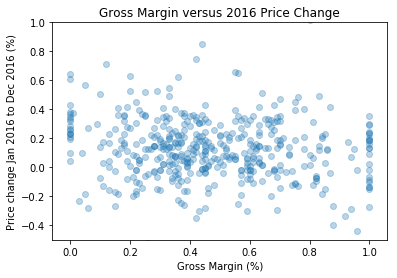

In [45]:
# Plot gross margin versus 2016 price change (%)

plt.scatter(x = gross_v_change.gross, y = gross_v_change.perc_change, alpha = 0.3)
plt.ylim([-0.5,1.0])
plt.xlabel("Gross Margin (%)")
plt.ylabel("Price change Jan 2016 to Dec 2016 (%)")
plt.title("Gross Margin versus 2016 Price Change")

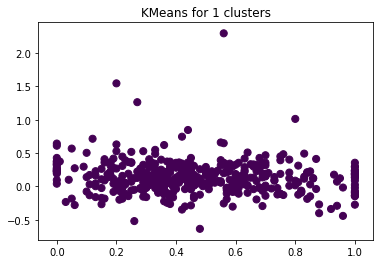

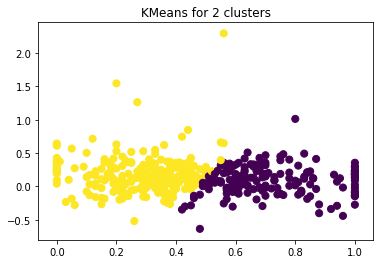

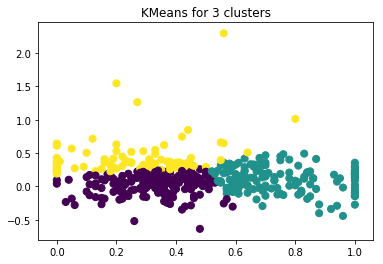

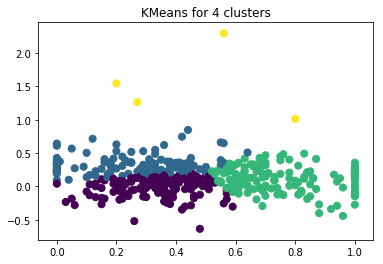

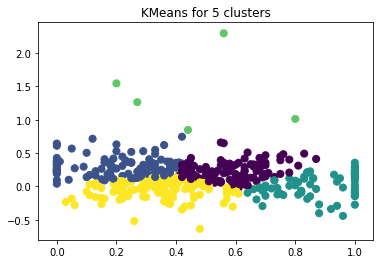

In [46]:
# Create one array

X = gross_v_change[['gross', 'perc_change']].values

# Fit KMeans for k in [1,5] to see potential clusters

for k in range(1,6):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
    plt.title("KMeans for {n} clusters".format(n=str(k)))
    plt.show()

## Summary Financial Clustering

In reality, it's very hard to find clean, distinct clusters in financial data. Groups of 1 or 2 stocks may seem like outliers but, it's those uncorrelated few that can give a portfolio manager an edge. 

The KMeans where n_components = 5 provided the most satisfying clusters. First, it divided the data set by positive and negative growth rate. Second, it grouped the 4 stocks with unusually high price increases. Third, it segmented the clusters by high, medium, and low gross margins. 

Investors bring their own biases to categorization. For example, the standard McKinsey style 2 X 2 arbitrarily groups data into quandrants. KMeans could be an interesting alternatively to human-determined factor defnitions. 

## 3) Forecast the overnight stock price change direction

We want to forecast the direction of the overnight price change (between t0 close and t1 open prices) using the historical price and volume data. For instance, we use 01/05/2010's features as the training data and 01/06/2010's overnight price change direction as the training label to fit a model. Then we use 01/06/2010's features as the testing data and 01/07/2010's overnight price change direction as the testing label to evaluate the model. This process is repeated for all the dates available in the dataset. A trading strategy is formed using the model predictions that buys the stocks with predicted positive return at the market close price, and sell them the next day at the open price.  
  
We applied three models to explore the opportunity: random forest regressor, random forest classifer and and logistic regression. The random forest classifier model achieved the best results, however the precision rate is not good enough to form a profitable trading strategy.

### Pre-requisites
Env: python 3.6, latest anaconda3 distribution  
- joblib  
conda install joblib  
Windows users are recommended to download and install the package directly from the github page https://github.com/joblib/joblib, as a Windows-specific bug was fixed in the recent master release but has not been pushed to conda repo yet.

In [47]:
import pandas as pd
import numpy as np

import os
import sys
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.finance as mpf
import random
from joblib import Parallel, delayed

%matplotlib inline

### Plotting

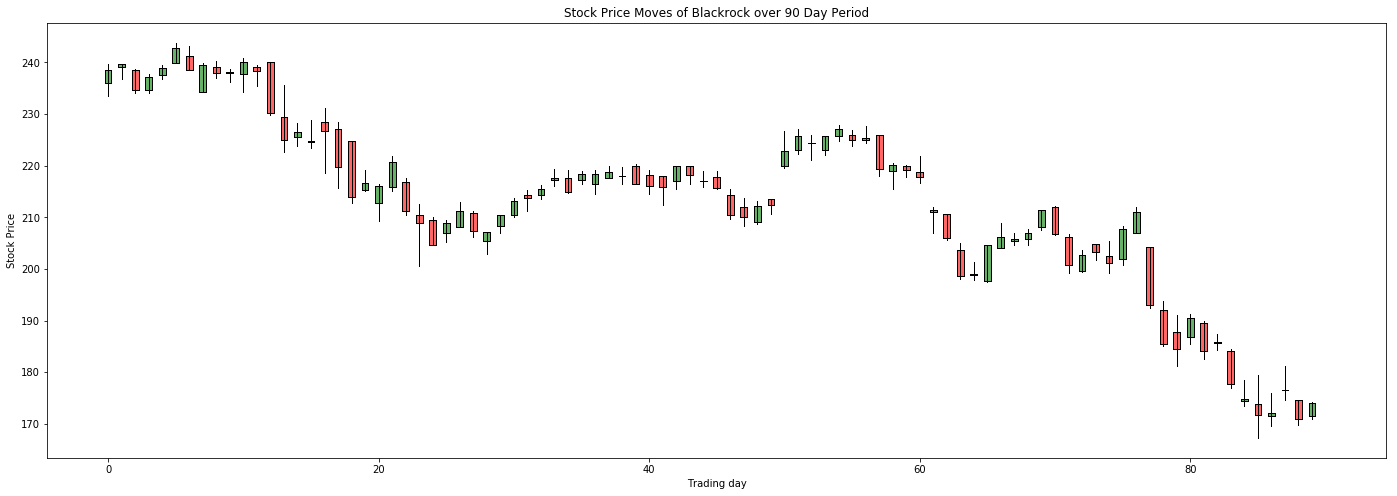

In [48]:
data = prices_adj.loc['BLK', ['open','close','high','low','volume']][:90]
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
plt.title('Stock Price Moves of Blackrock over 90 Day Period')
plt.xlabel('Trading day')
plt.ylabel('Stock Price')
mpf.candlestick2_ochl(ax, data['open'], data['close'], data['high'], data['low'], width=0.5, colorup='green', colordown='red', alpha=0.6)

### Normalize the prices entries using the t-1 close price  
- Effectively it's the daily return calculated as the difference of the log(price)  
- The price movement is modeled as a Wiener process (aka a random walk) in this analysis. Under this assumption,  
    - Return has normal distribution
    - Sometimes people use the Poisson process to model jumps, I stick with Wiener process for its simplicity.  
- Log transformation is performed to calculate the return  
    - Normally $return = (price_{t} - price_{t-1}) / price_{t-1}$, it can be approximate as $return = log(price_{t})-log(price_{t-1})$. 
    - The later can be more efficiently calculated, especially when calculating the cumulative.

In [49]:
ret = prices_adj.copy()

# Log transfrom the prices   
for col in ['open','close','low','high']:
    ret[col] = np.log(ret[col])
    
# Get the close price of the previous day
ret['close_m1'] = ret['close'].shift(1)

# Calculate normalize the prices using t-1 close price
ret.eval("""
            open = open - close_m1
            close = close - close_m1
            high = high - close_m1
            low = low - close_m1
         """,
             inplace = True)

# Drop close_m1
ret.drop(labels=['close_m1'], axis='columns', inplace=True)

# Drop the first entry for each ticker
idx = ret.groupby('symbol').head(1).index
ret.drop(labels=idx, axis='index', inplace=True)

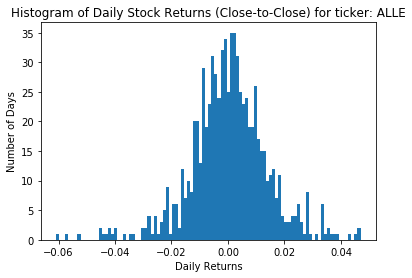

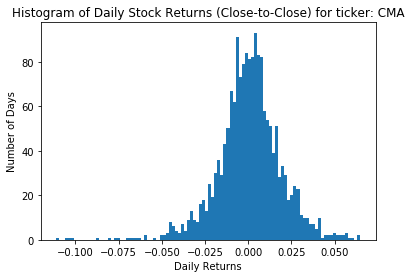

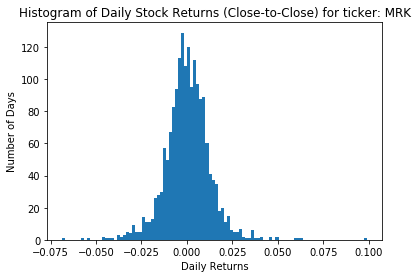

In [50]:
# The normal distribution assumption

for i in random.choices(symbols, k=3):
    plt.hist(ret.loc[i, 'close'], bins=100)
    plt.title("Histogram of Daily Stock Returns (Close-to-Close) for ticker: "+i)
    plt.xlabel("Daily Returns")
    plt.ylabel("Number of Days")
    plt.show()

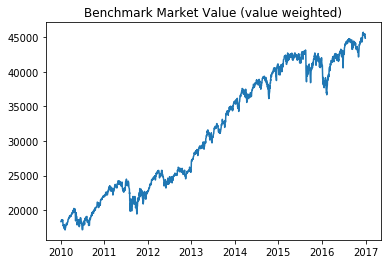

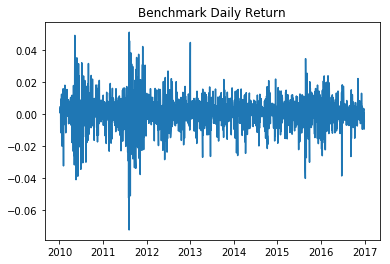

In [51]:
# Calculate the index return (baseline)

df = prices_adj.reset_index('symbol').sort_index()
bench = df.groupby(df.index)[['close']].sum()
plt.plot(bench)
plt.title("Benchmark Market Value (value weighted)")
plt.show()

bench_ret = np.log(bench) - np.log(bench.shift(1))
plt.plot(bench_ret)
plt.title("Benchmark Daily Return")
plt.show()

del(df)

In [52]:
# Calculate the daily active return (stock return - benchmark return)

ret = ret.swaplevel().sort_index()
ret['active'] = ret['close'] - bench_ret['close']

ret = ret.swaplevel().sort_index()

In [53]:
%%time
# Some feature engineering

def calc_features(symbol):
        
    df = ret.loc[[symbol]].copy()
        
    # Assign the daily return into buckets
#     df.loc[df['close']<=-0.05, 'ret_bucket_1'] = 1
#     df.loc[(df['close']>-0.05)&(df['close']<=-0.03), 'ret_bucket_2'] = 1
#     df.loc[(df['close']>-0.03)&(df['close']<=-0.01), 'ret_bucket_3'] = 1
#     df.loc[(df['close']>-0.01)&(df['close']<=0), 'ret_bucket_4'] = 1
#     df.loc[(df['close']>0)&(df['close']<=0.01), 'ret_bucket_5'] = 1
#     df.loc[(df['close']>0.01)&(df['close']<=0.03), 'ret_bucket_6'] = 1
#     df.loc[(df['close']>0.03)&(df['close']<=0.05), 'ret_bucket_7'] = 1
#     df.loc[df['close']>=0.05, 'ret_bucket_8'] = 1
#     df.fillna(0, axis=1, inplace=True)
    
    for period in [5, 10, 20, 30, 60, 90]:
        # Momentum (cumulative return of the previous n days)
        exec("""df['cum_ret_%s'] = df['close'].rolling(period).sum().values"""  % period)

        # Standard deviation
        exec("""df['std_%s'] = df['close'].rolling(period).std().values"""  % period)

        # relative volume (t0 : average over the period (t-n, t-1))
        exec("""df['vol_to_avg_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).mean()).values"""  % period)

        # relative volume (t0 : median over the period (t-n, t-1))
#         exec("""df['vol_to_med_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).median()).values"""  % period)

        # Highs and lows
        exec("""df['high_%s'] = df['high'].rolling(period).max().values"""  % period)
        exec("""df['low_%s'] = df['low'].rolling(period).min().values"""  % period)

    # Append previous 60 days' daily return
    for period in range(1, 61):
        exec("""df['close_t_m%s'] = df['close'].shift(period)"""  % period)
        exec("""df['open_t_m%s'] = df['open'].shift(period)"""  % period)
        exec("""df['high_t_m%s'] = df['high'].shift(period)"""  % period)
        exec("""df['low_t_m%s'] = df['low'].shift(period)"""  % period)
    
    return df

# Kick it off with multi threading
out = Parallel(n_jobs=-1, backend="threading")(delayed(calc_features)(s) for s in symbols)
    
features = pd.concat(out)
features.drop(['volume'], axis=1, inplace=True)
features = features.swaplevel().sort_index()
del(out)

Wall time: 1min 6s


### Define train and test data

Due to the nature of the panel data, the train and test data is splitted on a rolling basis. for example, during the training stage I use 01/05/2010's features as the X and 01/06/2010's return as the y to fit a model. To test this model, I need to use 01/06/2010's features as the test data and 01/07/2010's return as the test label to evaluate the model. This process is repeated for all the dates.

In [54]:
dates = features.reset_index()[['date']].drop_duplicates().reset_index(drop=True)
dates.rename_axis({'date': 'X_train'}, axis=1, inplace=True)
dates['y_train'] = dates['X_train'].shift(-1)
dates['X_test'] = dates['X_train'].shift(-1)
dates['y_test'] = dates['X_test'].shift(-1)
dates['trade_date'] = dates['X_test']
dates.set_index('trade_date', inplace=True)

dates.dropna(axis=0, inplace=True)

In [55]:
dates.head()

,X_train,y_train,X_test,y_test
trade_date,,,,
2010-01-06,2010-01-05,2010-01-06,2010-01-06,2010-01-07
2010-01-07,2010-01-06,2010-01-07,2010-01-07,2010-01-08
2010-01-08,2010-01-07,2010-01-08,2010-01-08,2010-01-11
2010-01-11,2010-01-08,2010-01-11,2010-01-11,2010-01-12
2010-01-12,2010-01-11,2010-01-12,2010-01-12,2010-01-13


In [56]:
dates.tail()

,X_train,y_train,X_test,y_test
trade_date,,,,
2016-12-22,2016-12-21,2016-12-22,2016-12-22,2016-12-23
2016-12-23,2016-12-22,2016-12-23,2016-12-23,2016-12-27
2016-12-27,2016-12-23,2016-12-27,2016-12-27,2016-12-28
2016-12-28,2016-12-27,2016-12-28,2016-12-28,2016-12-29
2016-12-29,2016-12-28,2016-12-29,2016-12-29,2016-12-30


In [57]:
def train_test_split(date):

    X_train = features.loc[dates.loc[date, 'X_train']].dropna(axis=0)
    y_train = features.loc[dates.loc[date, 'y_train'],'open'].dropna(axis=0)
    X_test = features.loc[dates.loc[date, 'X_test']].dropna(axis=0)
    y_test = features.loc[dates.loc[date, 'y_test'],'open'].dropna(axis=0)

    # Keep only the symbols that are in both sets
    X_train = X_train.loc[X_train.index.intersection(y_train.index)].sort_index()
    y_train = y_train.loc[y_train.index.intersection(X_train.index)].sort_index()
    X_test = X_test.loc[X_test.index.intersection(y_test.index)].sort_index()
    y_test = y_test.loc[y_test.index.intersection(X_test.index)].sort_index()

    # Make a binary y (1 for positive return, 0 for negative return)
    y_bin_train = (y_train > 0) * 1
    y_bin_test = (y_test > 0) * 1

    return X_train.as_matrix(), y_train.as_matrix(), y_bin_train.as_matrix(), X_test.as_matrix(), y_test.as_matrix(), y_bin_test.as_matrix()
#     return X_train, y_train, y_bin_train, X_test, y_test, y_bin_test

### Baseline
The baseline strategy trades all the stocks overnight (buy at t0 close, sell at t+1 open), equal weighted.

In [58]:
tmp = features.reset_index('symbol').loc[dates.index[90:], ['symbol', 'close']]

In [59]:
# Calculate the baseline daily return
baseline = []
for date in tmp.index.unique():
    baseline.append([date, tmp.loc[date,'close'].mean()])
    
baseline = np.array(baseline)

Text(0.5,1,'Baseline Cumulative Return')

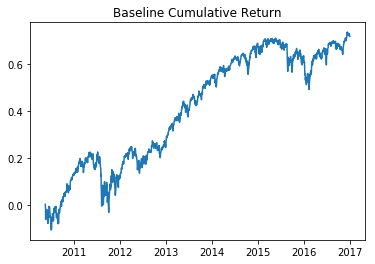

In [60]:
plt.plot(baseline[:,0], np.cumsum(baseline[:,1]))
plt.title("Baseline Cumulative Return")

### Random Forest
#### Regressor

In [61]:
%%time

def evaluate_rf_regr(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    regr = RandomForestRegressor(n_estimators=20, random_state=1, n_jobs=1, bootstrap=True, criterion='mse')
    
    try:
        regr.fit(X_train, y_train)
    except ValueError:
        return [date, np.nan, np.nan]
        
    y_pred = regr.predict(X_test)
    
    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred * y_test > 0) / len(y_test)
    
    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred > 0]) > 0:
        strat_return = np.mean(y_test[y_pred > 0])
    else:
        strat_return = 0
    return [date, accu_d, strat_return]



# Kick it off with multi-threading
out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_regr)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
# out = []
# for date in dates.index:
#     out.append(evaluate_rf_regr(date))


result_rf_regr = np.array(out)

Wall time: 6min 24s


In [62]:
# Average accuracy for predicting direction
np.mean(result_rf_regr[:, 1])

0.47871966220892365

Text(0.5,1,'Return - Random Forest Regression')

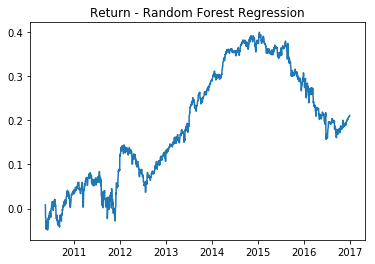

In [63]:
# Strategy cumulative return
plt.plot(result_rf_regr[:, 0], np.cumsum(result_rf_regr[:, 2]))
plt.title("Return - Random Forest Regression")

#### Classifier

In [64]:
%%time

def evaluate_rf_clf(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = RandomForestClassifier(n_estimators=40, random_state=1, n_jobs=1, bootstrap=True, criterion="gini")

    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan, np.nan, np.nan, np.nan]
        
    y_pred = clf.predict(X_test)
    
    # Calculate the precision of the direction prediction
    if sum(y_pred==1) > 0:
        prec_up = sum((y_pred==1)&(y_bin_test==1)) / sum(y_pred==1)
    else:
        prec_up = np.nan
    
    if sum(y_pred==0) > 0:
        prec_down = sum((y_pred==0)&(y_bin_test==0)) / sum(y_pred==0)
    else:
        prec_down = np.nan
    
    # Calculate the accuracy of correct predictions in either directions
    accu = sum(y_pred + y_bin_test != 1) / len(y_pred)
    
    # Create a long only strategy to equally buy the stocks with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        ret_long = np.mean(y_test[y_pred==1])
    else:
        ret_long = 0

    # Create a long-short strategy to buy the stocks with predicted positive overnight return and short the stocks with predicted negative return
    if len(y_test[y_pred == 0]) > 0:
        ret_short = -np.mean(y_test[y_pred==0])
    else:
        ret_short = 0
        
    ret_ls = ret_long + ret_short
        
        
    return [date, prec_up, prec_down, accu, ret_long, ret_ls]


# Run with multi-threading
# out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_rf_clf)(date) for date in dates.index[90:])


# Try this if multi-threading did not work
out = []
for date in dates.index[90:]:
    out.append(evaluate_rf_clf(date))

result_rf_clf = np.array(out)
del(out)

Wall time: 4min 6s


In [65]:
## Average precision
# Up
print(np.nanmean(result_rf_clf[:, 1]))

# Down
print(np.nanmean(result_rf_clf[:, 2]))

## Average accuracy
print(np.nanmean(result_rf_clf[:, 3]))

0.5054825992393306
0.4944142379709734
0.48631341761756486


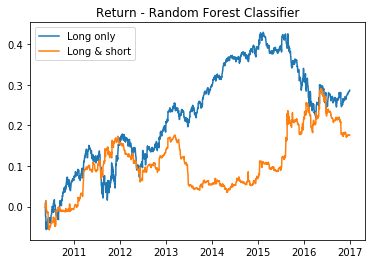

In [66]:
# Strategy cumulative return
plt.title("Return - Random Forest Classifier")
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 4]))
plt.plot(result_rf_clf[:, 0], np.cumsum(result_rf_clf[:, 5]))
plt.legend(["Long only", "Long & short"])

### Logistic Regression

In [67]:
%%time

def evaluate_log_reg(date, C):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    clf = LogisticRegression(penalty='l2', tol=0.0001, C=C)
    
    try:
        clf.fit(X_train, y_bin_train)
    except ValueError:
        return [date, np.nan, np.nan]

    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred + y_bin_test != 1) / len(y_test)

    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred == 1]) > 0:
        strat_return = np.mean(y_test[y_pred == 1])
    else:
        strat_return = 0

    return [date, accu_d, strat_return]



# Find the best C value
max_accu = 0
C_max_accu = 0
max_ret = -1
C_max_ret = 0

for c in np.linspace(0.05, 1, 20):
    out = Parallel(n_jobs=-1, backend="threading")(delayed(evaluate_log_reg)(date, c) for date in dates.index[90:])
    result_log_reg = np.array(out)
    
    accu = np.nanmean(result_log_reg[:, 1])
    if accu > max_accu:
        max_accu = accu
        C_max_accu = c
        result_log_reg_max_accu = result_log_reg.copy()

    total_ret = np.nansum(result_log_reg[:, 2])
    if total_ret > max_ret:
        max_ret = total_ret
        C_max_ret = c
        result_log_reg_max_ret = result_log_reg.copy()
    
print(max_accu, C_max_accu, max_ret, C_max_ret)

0.4796651747055997 1.0 0.12187305210596854 1.0
Wall time: 8min 23s


In [68]:
# Average accuracy for predicting direction
np.nanmean(result_log_reg[:, 1])

0.4796651747055997

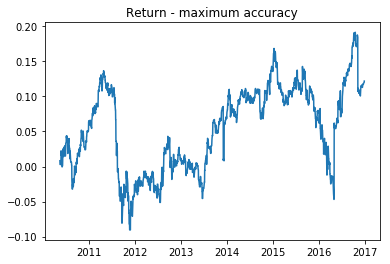

Text(0.5,1,'Return - maximum return')

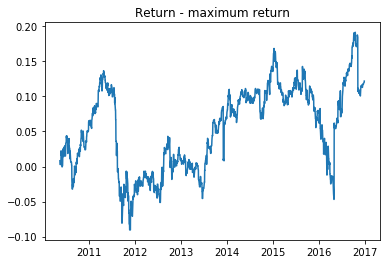

In [69]:
# Strategy cumulative return

# Maximum accuracy
plt.plot(result_log_reg_max_accu[:, 0], np.nancumsum(result_log_reg_max_accu[:, 2]))
plt.title("Return - maximum accuracy")
plt.show()

# Maximum return
plt.plot(result_log_reg_max_ret[:, 0], np.nancumsum(result_log_reg_max_ret[:, 2]))
plt.title("Return - maximum return")

## Summary of Forecasting
Predicting the short term stock price direction is extremely difficult and there are no state of the art researching work available (you do not want to share your results if you manage to come up with a competative strategy). Our best results yield a ~50% prediction precision, which is no better than randomly guessing. In the future development, we will try to impelment the similar approach to predict the mid-term (e.g. 20-day) price movement direction.